# Titanic survival

Given a dataset of Titanic passengers, predict which ones survived.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

#Machine learning
import sklearn as sk

In [2]:
#Read data
train = pd.read_csv("./csv/train.csv")
test = pd.read_csv("./csv/test.csv")
test_class = pd.read_csv("./csv/gender_submission.csv")

#Data preview
train.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


## Preprocess data

We'll select as features
* Passenger class
* Sex
* Age (When age is NaN, we use the mean value of each class as a default value)

In [3]:
def process_nan_ages(data):
    clean_data = (data.dropna())
    survived = data[data.Survived == 1]
    died = data[data.Survived == 0]
    avg_survived = survived.Age.mean()
    avg_died = died.Age.mean()
    data.loc[(data.Survived == 0) & (data.Age.isnull()), 'Age'] = avg_died
    data.loc[(data.Survived == 1) & (data.Age.isnull()), 'Age'] = avg_survived 

In [4]:
#Assing numeric values to sex
train.Sex = train.Sex.replace('male', 0)
train.Sex = train.Sex.replace('female', 1)

#Fix NaN values on age field
process_nan_ages(train)

#Select features
train_features = train[['Pclass', 'Sex', 'Age']]
train_class = train['Survived']

#Preview trainning set
train_features.head(10)

,Pclass,Sex,Age
0,3,0,22.000000
1,1,1,38.000000
2,3,1,26.000000
3,1,1,35.000000
4,3,0,35.000000
5,3,0,30.626179
6,1,0,54.000000
7,3,0,2.000000
8,3,1,27.000000
9,2,1,14.000000


### Preprocess test set

In [5]:
#Join 'survived' values in test
test = pd.merge(test, test_class, how = "left", on = "PassengerId")

#Assign numeric values to sex
test.Sex = test.Sex.replace('male', 0)
test.Sex = test.Sex.replace('female', 1)

#Fix NaN values on age field
process_nan_ages(test)

#Select features
test_features = test[['Pclass', 'Sex', 'Age']]
test_class = test['Survived']

#Preview trainning set
test_features.head()

,Pclass,Sex,Age
0,3,0,34.5
1,3,1,47.0
2,2,0,62.0
3,3,0,27.0
4,3,1,22.0


## Machine learning with scikit-learn

### KNN
#### Picking best KNN parameters for our dataset

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
k_range = range(1,30)
params = dict(n_neighbors = list(k_range))

grid = GridSearchCV(knn, params, cv = 10, scoring = 'accuracy', n_jobs = -1)
grid.fit(train_features, train_class)

GridSearchCV(cv=10, error_score='raise',
       estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring='accuracy', verbose=0)

In [7]:
#Our best choice
print(grid.best_params_)
best_n_neighbors = grid.best_params_['n_neighbors']

{'n_neighbors': 2}


#### Training our model with the best parameter

In [8]:
from sklearn.metrics import accuracy_score

knn = KNeighborsClassifier(n_neighbors = best_n_neighbors)
knn.fit(train_features, train_class)

#Testing our model actual accuracy
test_pred = knn.predict(test_features)
accuracy_score(test_class, test_pred)

0.77511961722488043

### Linear SVC

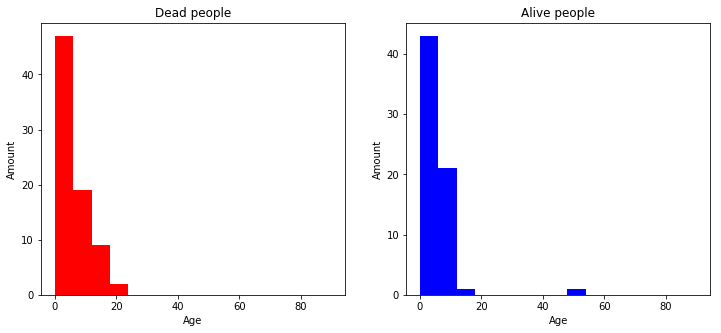

In [9]:
dead_age = train[train.Survived == 0]
dead_age = dead_age.groupby('Age')
dead_age = dead_age.size()
alive_age = train[train.Survived == 1]
alive_age = alive_age.groupby('Age')
alive_age = alive_age.size()

fig, (ax_d, ax_a) = plt.subplots(ncols=2, figsize=(12, 5))
ax_d.set_title("Dead people")
ax_d.set_xlabel("Age")
ax_d.set_ylabel("Amount")
ax_a.set_title("Alive people")
ax_a.set_xlabel("Age")
ax_a.set_ylabel("Amount")

ax_d.hist(dead_age, 15, range = [0, 90], color = 'r')
ax_a.hist(alive_age, 15, range = [0, 90], color = 'b')
plt.show()

#### Pick best C parameter for Linear SVC

In [10]:
from sklearn.svm import LinearSVC

c_range = np.arange(0.1, 5.0, 0.2)
params = dict(C = c_range)
svc = LinearSVC()
grid = GridSearchCV(svc, params, cv = 10, scoring = 'accuracy', n_jobs = -1)
grid.fit(train_features, train_class)

print(grid.best_params_)
best_c = grid.best_params_['C']

{'C': 0.10000000000000001}


#### Train model using best C

In [11]:
svc = LinearSVC(C = best_c)
svc.fit(train_features, train_class)

svc_test_pred = svc.predict(test_features)
accuracy_score(test_class, svc_test_pred)

0.9856459330143541